### The 2d Darcy's Flow 
The Darcy's problem is given as:
\begin{equation}
\begin{cases}
- \nabla(\cdot a(x) \nabla u(x)) &= f(x), \quad x\in\Omega\\
       u  &=0, \quad x\in\partial\Omega
\end{cases}
\end{equation}
where $\Omega=[0,1]^2$. We consider the coefficient $a(x)$ with the following form:
\begin{equation}
a(x) =
\begin{cases}
2, \quad x_1<0.5 \\
10. \quad x_1>0.5
\end{cases}
\end{equation}

### (1) Prepare the data

<KeysViewHDF5 ['X', 'Y', 'a_true', 'dux_fem', 'duy_fem', 'u_fdm', 'u_fem']>


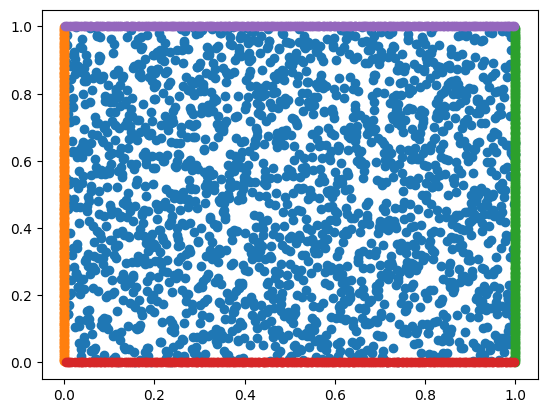

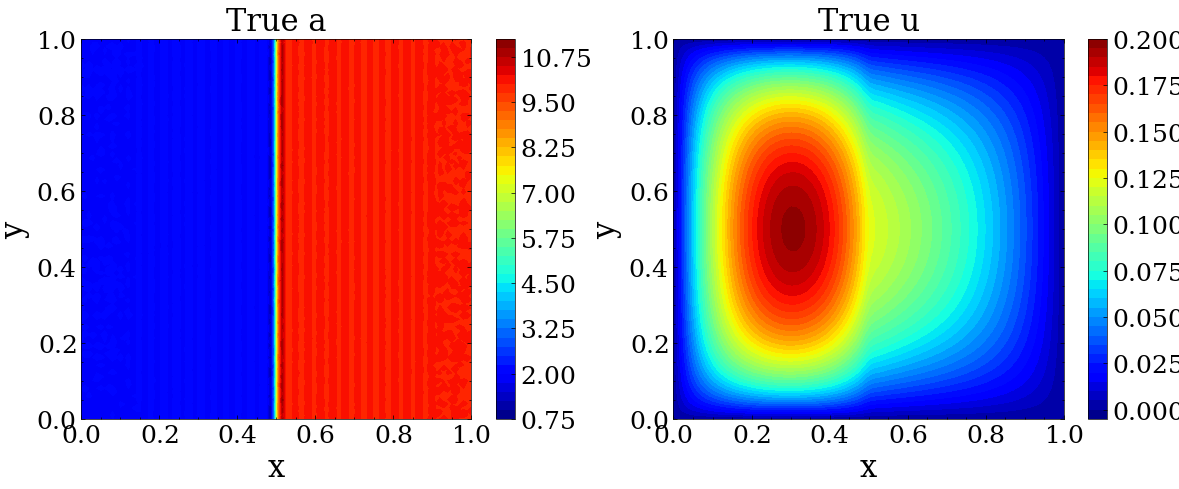

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Darcy_Flow_pwc2d'
######################################
# Load reference data
######################################
from Utils.utils import *
data = h5py.File('../../Problems/Darcy_Flow/truth_pwc_2d.mat', 'r')
print(data.keys())
#
u_test = np2tensor(np.array(data['u_fem']).reshape(-1,1), dtype)
xx, yy = np.meshgrid(np.linspace(0,1.,64), np.linspace(0., 1., 64))
x_test = np2tensor(np.vstack([xx.flatten(), yy.flatten()]).T, dtype)
######################################
# Generate training data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 2000, 200
xc_train, R_train = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.show()
##########################################
from Utils.PlotFigure import Plot
#
class Fun_a(object):

    def __init__(self):
        self.threshold = 0.5
        
    def __call__(self, x):
        '''
        Input:
            x: size( nx, 2)
        '''
        xx = x[...,0:1]
        a = torch.where(xx>=self.threshold, 10.*torch.ones_like(xx), 
                        2.*torch.ones_like(xx))
        return a.detach()
#
a_test = Fun_a()(x_test)
Plot.show_2d_list(x_test, [a_test, u_test], ['True a', 'True u'], lb=0.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=15, 
    dataType=dtype).get_testFun()

###############################
# The coefficient function
###############################
class Fun_a(object):

    def __init__(self):
        self.threshold = 0.5
        
    def __call__(self, x):
        '''
        '''
        xx = x[...,0:1]
        a = torch.where(xx>=self.threshold, 10.*torch.ones_like(xx), 
                        2.*torch.ones_like(xx))
        return a.detach()

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, grid):
        '''Define the mollifer
        '''
        x_mesh, y_mesh = grid[...,0:1], grid[...,1:2]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u
    
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.mollifer = mollifer()
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_a = Fun_a()
        self.model_u = solver.model_dict['u']
        self.model_s = solver.model_dict['s']
        ######################## 
        self.int_grid = int_grid.to(self.solver.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.solver.device)
        self.dv_dr = dphi_dr.to(self.solver.device)
        
    def Loss_pde(self, xc=None, R=None):
        '''Define the PDE loss
        '''
        # ################################## 
        xc, R = xc_train.to(self.device), R_train.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ##########################################
        a = self.model_a(x)
        u = self.model_u(x)
        if self.mollifer is not None:
            u = self.mollifer(u, x)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        s = self.model_s(x)
        ###########################################
        res1 = torch.mean(torch.sum( (s - a * du)**2, dim=-1))
        right = torch.sum( s * dv, dim=-1).reshape(nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        #
        left = (f * v).reshape(nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        res2 = torch.mean( (left-right)**2 ) * np.sqrt(nc)
        
        return res1 + res2

    def Loss_bd(self):
        ''' '''
        loss = torch.tensor(0., device=self.solver.device)
        
        return loss * 1.
        
    def Error(self):
        '''
        '''
        x = x_test.to(self.device)
        u = u_test.to(self.device)
        ####### 
        u_pred = self.model_u(x)
        if self.mollifer is not None:
            u_pred = self.mollifer(u_pred, x)
        #
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN
#
solver = ParticleWNN.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')
model_s = solver.getModel([2, 40, 40, 40, 2], 'Tanh_Sin', netType='FCNet')

### (3) training and prediction

#### (3.1) Train the model

In [3]:
model_dict = {'u':model_u, 's':model_s}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, max_iter=1000)
solver.train(LossClass, xc_train, R_train, batch_size_in=50, epochs=500, epoch_show=50,
             **{'save_path':f'saved_models/pwc/'})

 10%|█████                                              | 50/500 [00:37<05:31,  1.36it/s]

Epoch:50 Time:37.0466, loss_in:0.092538, loss_bd:0.000000
          lr: 0.001 l2_err 0.045904647558927536


 20%|██████████                                        | 100/500 [01:13<04:54,  1.36it/s]

Epoch:100 Time:73.9068, loss_in:0.047341, loss_bd:0.000000
          lr: 0.001 l2_err 0.027924006804823875


 30%|███████████████                                   | 150/500 [01:50<04:17,  1.36it/s]

Epoch:150 Time:110.7446, loss_in:0.032476, loss_bd:0.000000
          lr: 0.001 l2_err 0.02016710862517357


 40%|████████████████████                              | 200/500 [02:27<03:41,  1.36it/s]

Epoch:200 Time:147.5889, loss_in:0.026227, loss_bd:0.000000
          lr: 0.0005 l2_err 0.014436704106628895


 50%|█████████████████████████                         | 250/500 [03:04<03:04,  1.36it/s]

Epoch:250 Time:184.4721, loss_in:0.022702, loss_bd:0.000000
          lr: 0.0005 l2_err 0.012241600081324577


 60%|██████████████████████████████                    | 300/500 [03:41<02:27,  1.36it/s]

Epoch:300 Time:221.3091, loss_in:0.020992, loss_bd:0.000000
          lr: 0.0005 l2_err 0.010141978040337563


 70%|███████████████████████████████████               | 350/500 [04:18<01:50,  1.36it/s]

Epoch:350 Time:258.1469, loss_in:0.028052, loss_bd:0.000000
          lr: 0.0005 l2_err 0.00893094576895237


 80%|████████████████████████████████████████          | 400/500 [04:54<01:13,  1.36it/s]

Epoch:400 Time:294.9850, loss_in:0.018793, loss_bd:0.000000
          lr: 0.00025 l2_err 0.010926337912678719


 90%|█████████████████████████████████████████████     | 450/500 [05:31<00:36,  1.36it/s]

Epoch:450 Time:331.8696, loss_in:0.017609, loss_bd:0.000000
          lr: 0.00025 l2_err 0.009127442725002766


100%|██████████████████████████████████████████████████| 500/500 [06:08<00:00,  1.36it/s]

Epoch:500 Time:368.7146, loss_in:0.016965, loss_bd:0.000000
          lr: 0.00025 l2_err 0.009470408782362938
The total training time is 368.7231


#### (3.2) Make prediction

The l2_err is tensor([0.0087])


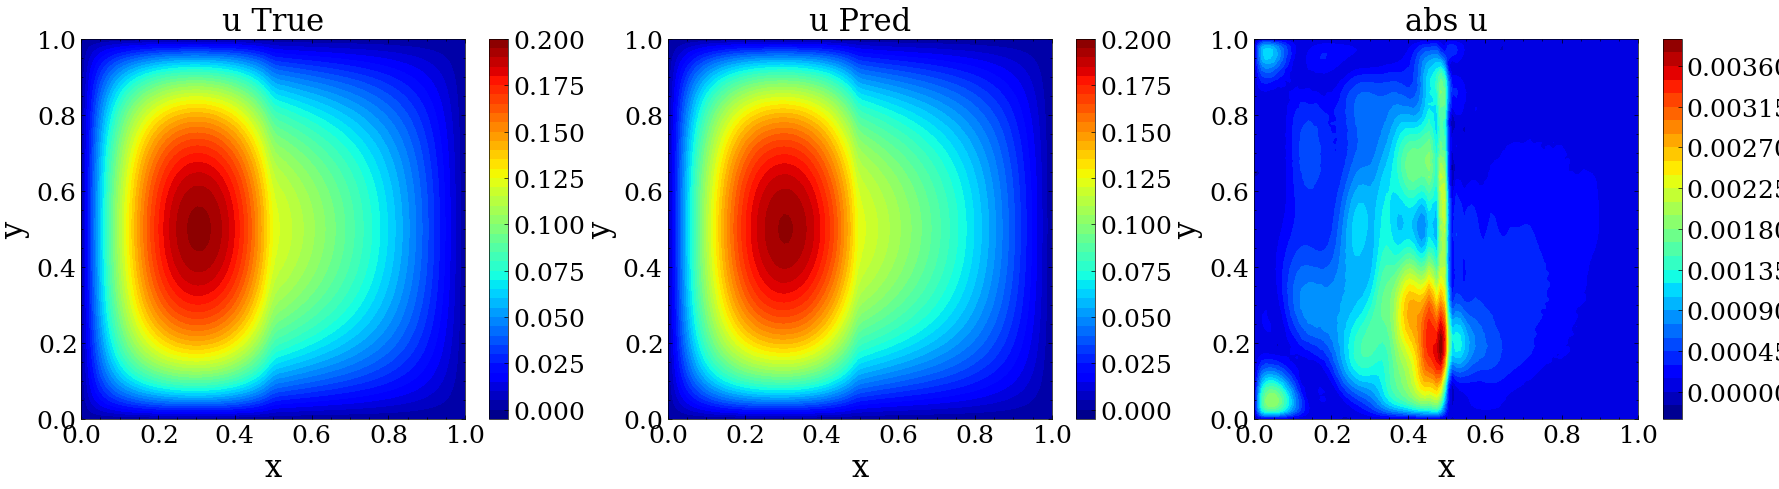

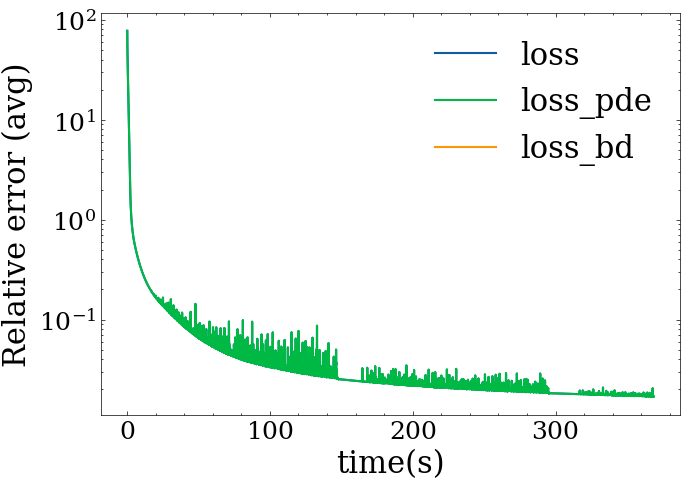

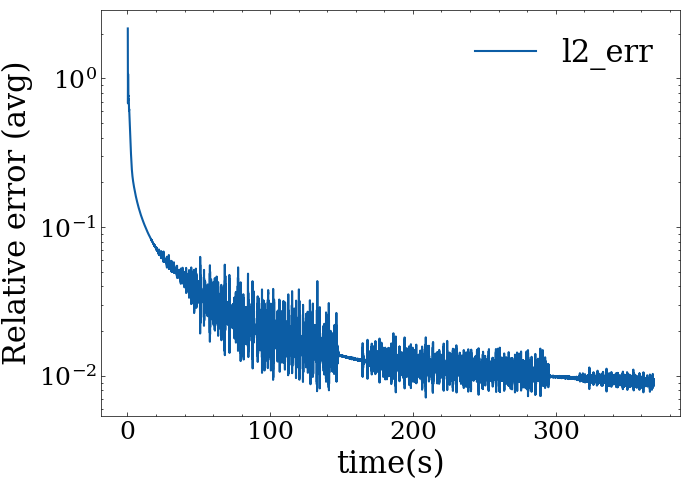

In [3]:
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/pwc/', name='model_particlewnn_final')

###############################
# make prediction
###############################
x_var = Variable(x_test, requires_grad=True).to(device)
u_var = model_trained['u'](x_var)
u_var = mollifer()(u_var, x_var)
u_var = u_var.detach().cpu()
#
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(x_test, [u_test, u_var, abs(u_test-u_var)], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path=f'saved_models/pwc/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])